In [1]:
import pandas as pd
import numpy as np
from numpy import array
from skimage.io import imshow
from sklearn import metrics as mt
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import seaborn as sns
from keras.models import load_model

/Users/ericsmith/anaconda/envs/MachineLearning/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train = pd.read_pickle("./Data/train.pickle")
test = pd.read_pickle("./Data/test.pickle")
classes = open('./Data/classes.txt', 'r').read().split()

img_wh = 50

For some reason, the extract.py script left some pixel values as greater than 0 but less than 1.

In [3]:
train[0]['features'].shape

(2500,)

In [4]:
# put more instances in testing to make it an 80/20 split
split = int((len(train) + len(test)) * .8)
test = np.append(test, train[split:])
train = train[:split-1]

In [5]:
X_train = []
X_test = []
y_train = []
y_test = []
y_train_ohe = []
y_test_ohe = []

for elem in train:
    X_train.append(elem['features'])
    y_train.append(np.argmax(elem['label'], axis=0))
    y_train_ohe.append(elem['label'])
    
for elem in test:
    X_test.append(elem['features'])
    y_test.append(np.argmax(elem['label'], axis=0))
    y_test_ohe.append(elem['label'])
    
X_train = array(X_train).reshape((-1,img_wh,img_wh))
y_train = array(y_train)
y_train_ohe = array(y_train_ohe)
X_test = array(X_test).reshape((-1,img_wh,img_wh))
y_test = array(y_test)
y_test_ohe = array(y_test_ohe)

NUM_CLASSES = len(y_train_ohe[0])

In [6]:
print(X_train.shape)
print(X_test.shape)
print(y_train_ohe.shape)
print(y_test_ohe.shape)

(121192, 50, 50)
(30299, 50, 50)
(121192, 17)
(30299, 17)


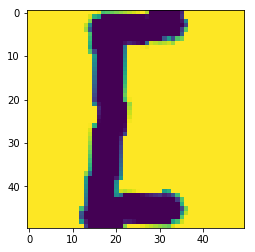

class: [


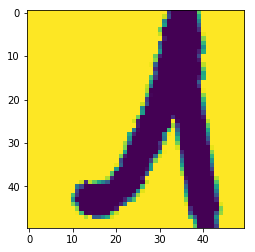

class: 1


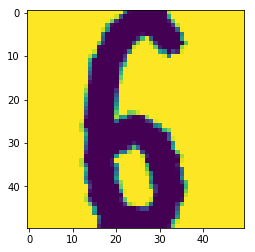

class: 6


In [7]:
for i in range(3):
    plt.imshow(X_train[i].squeeze())
    plt.show()
    print("class: " + classes[y_train[i]])

In [8]:
%%time 

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None)

X_t = np.expand_dims(X_train,axis=-1)
X_s = np.expand_dims(X_test,axis=-1)

datagen.fit(X_t)

cnn = Sequential()
cnn.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh, 1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
cnn.fit_generator(datagen.flow(X_t, y_train_ohe, batch_size=128), 
                   steps_per_epoch=int(len(X_train)/1024), # how many generators to go through per epoch
                   epochs=1, verbose=5,
                   validation_data=(X_s, y_test_ohe)
                  )

(121192, 50, 50, 1)
Epoch 1/1
CPU times: user 15min 15s, sys: 1min 20s, total: 16min 35s
Wall time: 4min 38s


In [13]:
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(np.expand_dims(X_test,axis=-1)), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
    plt.title(title_text+'{:.4f}'.format(acc))
    plt.show()

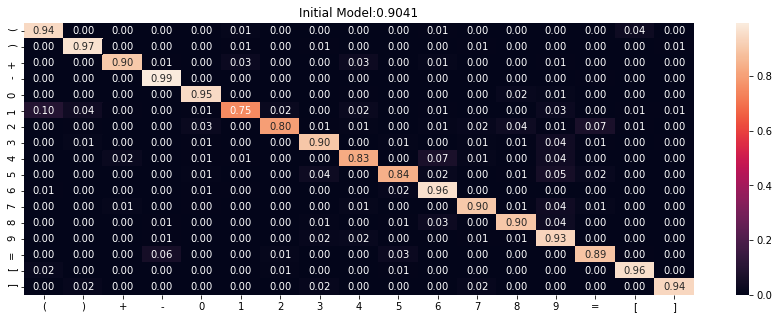

In [14]:
summarize_net(cnn, X_test, y_test, title_text='Initial Model:')

In [15]:
cnn.save('cnn_11_10.h5')

----

In [33]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# helper function for sorting sub images by X value
def sort_list(list1, list2):
    zipped_pairs = zip(list2, list1)
    z = [x for _, x in sorted(zipped_pairs)]

    return z


"""
input: path to image file
output: a unique image for each character detected in an image
"""
def get_split_images(image_full_path):
    with open(image_full_path, 'rb') as img_stream:
        file_bytes = np.asarray(bytearray(img_stream.read()), dtype=np.uint8)
        im = cv2.imdecode(np.fromstring(file_bytes,dtype=np.uint8),cv2.IMREAD_COLOR)
        # im = cv2.imread(image,0)
    
        # im = cv2.imdecode(np.frombuffer(image,dtype=np.uint8),0)
    
        imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY) # convert to greyscale
    
        # detect contours
        ret,thresh = cv2.threshold(imgray,127,255,0)
        im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
        output_contours = []
        output_hierarchy = []
        output_xs = []
    
        # for each contour found
        for i, contour in enumerate(contours):
    
            # get rectangle bounding contour
            [x,y,w,h] = cv2.boundingRect(contour)
    
            # discard areas that are too large
            if h > 300 and w > 300:
                continue
    
            # discard areas that are too small
            if h < 40 or w < 40:
                continue
    
            roi = im[y:y + h, x:x + w]
    
            # store the character's image, its hierarchy, and its X value
            output_contours.append(roi)
            output_hierarchy.append(hierarchy[0,i,3])
            output_xs.append(x)
    
    
        # sort contours by X values
        output_contours = sort_list(output_contours, output_xs)
        output_hierarchy = sort_list(output_hierarchy, output_xs)
    
        # find the top level contour
        min_hierarchy = min(output_hierarchy)
    
        result = []
        # output contours that are on the top level
        for i in range(len(output_contours)):
            if output_hierarchy[i] == min_hierarchy:
                # cv2.imwrite(str(i) + '.jpg', output_contours[i])
                b, g, r = cv2.split(output_contours[i])
                a = np.ones(b.shape, dtype=b.dtype) * 50

                final_img = cv2.merge((b, g, r))
                
                final_img = cv2.normalize(final_img, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
                
                final_img = cv2.resize(final_img,(50,50))
            
                final_img = cv2.cvtColor(final_img,cv2.COLOR_BGR2GRAY)

                result.append(np.expand_dims(np.expand_dims(final_img,axis=-1),axis=0))
    
        return result

In [35]:
input_image = './Data/test.jpeg'
# get_split_images(input_image)
for image in get_split_images(input_image):
#     plt.imshow(image)
#     plt.show()
    print(classes[np.argmax(cnn.predict(image))])

]
-
1


/Users/ericsmith/anaconda/envs/MachineLearning/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
